## Setup

In [1]:
import numpy as np
import os
import cv2
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
print(tf.__version__)
print(cv2.__version__)

2.6.0
4.1.2


In [3]:
def load_image(path, dim=None):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if dim is not None:
        img = cv2.resize(img, dim)
    return img

### Download the flowers dataset

This tutorial uses a dataset of several thousand photos of flowers. The flowers dataset contains five sub-directories, one per class:

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

Note: all images are licensed CC-BY, creators are listed in the LICENSE.txt file.

In [4]:
#! wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

In [5]:
#!tar zxvf flower_photos.tgz

In [6]:
!ls flower_photos/

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


In [7]:
data_dir_str = 'flower_photos/'

After downloading (218MB), you should now have a copy of the flower photos available. There are 3,670 total images:

In [8]:
image_count = len(list(glob.glob(data_dir_str+'*/*.jpg')))
print(image_count)

3670


Each directory contains images of that type of flower. Here are some roses:

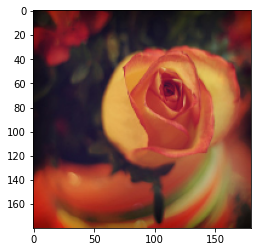

In [9]:
roses = list(glob.glob(data_dir_str+'roses/*'))
#print(roses)
plt.imshow(load_image(roses[0], (180,180)))
plt.show()

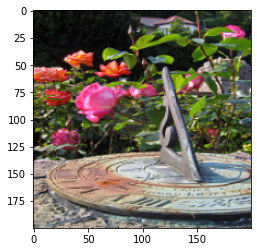

In [10]:
plt.imshow(load_image(roses[1], (200,200)))
plt.show()

## Load data using a custom loop



In [11]:
img_height = 180
img_width = 180

claases_dir = glob.glob(data_dir_str+'/*')
print(claases_dir)

class_map = {}
count = 0
images_list = []
labels_list = []
for i in range(len(claases_dir)):
    class_folder = claases_dir[i].split('/')[-1]
    if '.txt' not in class_folder:
        print(class_folder)        
        class_map[count] = class_folder
        images_paths_list = glob.glob(claases_dir[i]+'/*')
        for j in images_paths_list:
            images_list.append(load_image(j, (img_height, img_width)))
            labels_list.append(count)
        count = count + 1
images = np.array(images_list)/255.0  
labels = np.array(labels_list)

images, labels = shuffle(images, labels)
train_data_size = int(0.7*images.shape[0])
print(images.shape)
print(labels.shape)
print(train_data_size)
train_images, test_images = images[:train_data_size], images[train_data_size:]
train_labels, test_labels = labels[:train_data_size], labels[train_data_size:]

['flower_photos/dandelion', 'flower_photos/roses', 'flower_photos/tulips', 'flower_photos/daisy', 'flower_photos/sunflowers', 'flower_photos/LICENSE.txt']
dandelion
roses
tulips
daisy
sunflowers
(3670, 180, 180, 3)
(3670,)
2569


In [12]:
print(class_map)
def get_class(c=[]):
    return [class_map[x] for x in c]

print(get_class([1,1,2,0,4,3,3]))

{0: 'dandelion', 1: 'roses', 2: 'tulips', 3: 'daisy', 4: 'sunflowers'}
['roses', 'roses', 'tulips', 'dandelion', 'sunflowers', 'daisy', 'daisy']


In [13]:
def augmentation(images, labels, aug_percentage=0.5):
  shape = images.shape
  indxs = np.random.choice(shape[0], int(aug_percentage*shape[0]), replace=False)
  aug_imgs = []
  for i in indxs:
    img = images[i].copy()
    if np.random.random() > 0.5:
      img = cv2.flip( img, 0 )
    if np.random.random() > 0.5:
      img = cv2.flip( img, 1 )
    if np.random.random() > 0.5:
      angle = np.random.uniform(0,360)
      matrix = cv2.getRotationMatrix2D((shape[1]/2, shape[2]/2), angle, 1)
      img = cv2.warpAffine(img, matrix, (img.shape[1], img.shape[0]))
    if np.random.random() > 0.3:
      f_size = int(np.random.uniform(3,55))
      f_size = f_size - (f_size%2) + 1
      img = cv2.GaussianBlur(img, (f_size,f_size), 0)
    if np.random.random() > 0.5:
      img = img*255. + cv2.randn(img,(0,0,0),(10,10,10))
      img = img / 255.
    aug_imgs.append(img)
  return np.array(aug_imgs), labels[indxs]
  

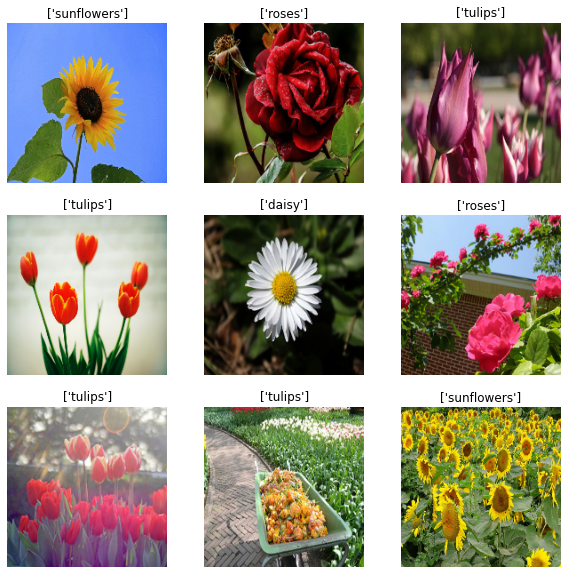

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


*


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


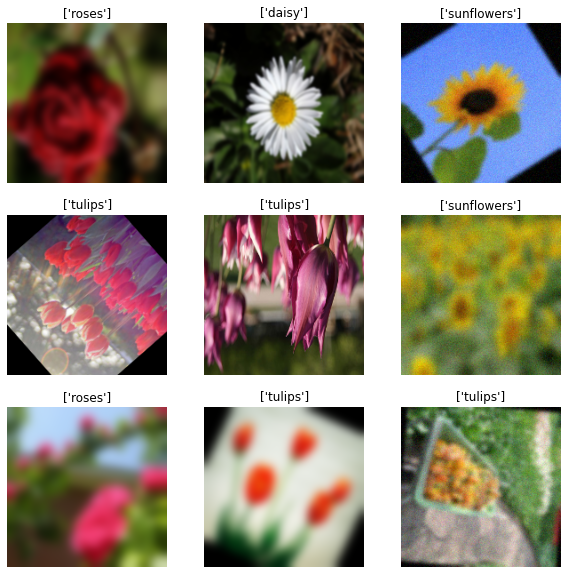

In [14]:
aug_img, aug_labels = augmentation(train_images[:9], train_labels[:9], aug_percentage=1.0)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i])
    plt.title(get_class([train_labels[i]]))
    plt.axis("off")
plt.show()
print('*')
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(aug_img[i])
    plt.title(get_class([aug_labels[i]]))
    plt.axis("off")
plt.show()

In [15]:
print(train_images.shape)
print(train_labels.shape)

aug_img, aug_labels = augmentation(train_images, train_labels, aug_percentage=0.5)
train_images = np.concatenate((train_images, aug_img))
train_labels = np.concatenate((train_labels, aug_labels))
train_images, train_labels = shuffle(train_images, train_labels)

print(train_images.shape)
print(train_labels.shape)

(2569, 180, 180, 3)
(2569,)
(3853, 180, 180, 3)
(3853,)


### Create a dataset

Define some parameters for the loader:

In [16]:
batch_size = 256


It's good practice to use a validation split when developing your model. You will use 80% of the images for training and 20% for validation.

### Visualize the data

Here are the first nine images from the training dataset.

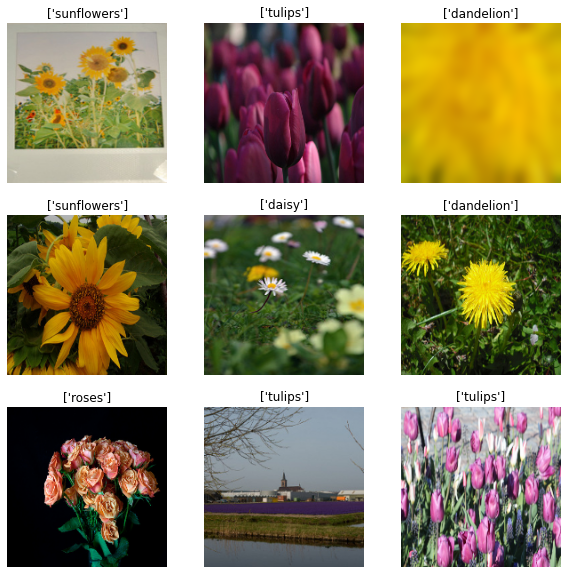

In [17]:
import matplotlib.pyplot as plt

lst = np.random.choice(range(len(train_labels)), size=9)
plt.figure(figsize=(10, 10))
for i in range(len(lst)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[lst[i]])
    plt.title(get_class([train_labels[lst[i]]]))
    plt.axis("off")

In [18]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 5, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 7, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Conv2D(128, 9, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [19]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(1e-4),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Note: You will only train for a few epochs so this tutorial runs quickly. 

In [ ]:
model.fit(
  train_images, train_labels,
  validation_split=0.3,
  epochs=25
)

Epoch 1/25


In [ ]:
predictions = np.argmax(model.predict(test_images[:9]), axis=1)
predictions = get_class(predictions)
labls = test_labels[:9]



plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])
    label = labls[i]
    plt.title(str(predictions[i]) + ' / '+ class_map[label])
    plt.axis("off")